In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from joblib import dump, load

from pyod.models.abod import ABOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.utils.utility import precision_n_scores, standardizer
from sklearn.metrics import auc, f1_score, roc_auc_score, roc_curve

from autocustom import AutoEncoderCustom

from datautil import *

In [4]:
def get_dataset(dataset_name: str):
    if dataset_name == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset_name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset_name == 'cifar10':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    elif dataset_name == 'kminst':
        x_train = np.load('./kmnist/kmnist-train-imgs.npz')['arr_0']
        x_test = np.load('./kmnist/kmnist-test-imgs.npz')['arr_0']
        y_train = np.load('./kmnist/kmnist-train-labels.npz')['arr_0']
        y_test = np.load('./kmnist/kmnist-test-labels.npz')['arr_0']
    else:
        raise('Error')

    return x_train, y_train, x_test, y_test

In [5]:
# config
dataset_name = "mnist"
dataset_name = "fashion_mnist"
#dataset_name = "kminst"
outlier_fraction = 0.1


x_train, y_train, x_test, y_test = get_dataset(dataset_name)

n_features = np.prod(x_train.shape[1:])
x_train = x_train.reshape(x_train.shape[0], n_features) / 255.0
x_test = x_test.reshape(x_test.shape[0], n_features) / 255.0

num_classes = np.unique(y_train).size
num_nodes_per_class = 9  # p parameter, set (to num_class - 1) * d

print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [6]:
# dict of dataset, key is client name 
datasets = partition(x_train,y_train,num_nodes_per_class, outlier_fraction)


div,rem 1 0


In [7]:
# verify
datasets.keys()
datasets['0_4']['y_class'].value_counts()

dict_keys(['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '3_0', '3_1', '3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '4_0', '4_1', '4_2', '4_3', '4_4', '4_5', '4_6', '4_7', '4_8', '5_0', '5_1', '5_2', '5_3', '5_4', '5_5', '5_6', '5_7', '5_8', '6_0', '6_1', '6_2', '6_3', '6_4', '6_5', '6_6', '6_7', '6_8', '7_0', '7_1', '7_2', '7_3', '7_4', '7_5', '7_6', '7_7', '7_8', '8_0', '8_1', '8_2', '8_3', '8_4', '8_5', '8_6', '8_7', '8_8', '9_0', '9_1', '9_2', '9_3', '9_4', '9_5', '9_6', '9_7', '9_8'])

0    602
5     68
Name: y_class, dtype: int64

In [8]:
# convert to object Dev
devs = []
for name, data, in datasets.items():
    #print(name,dataset_name)
    x = data.iloc[:,:n_features]
    y_class = data['y_class']
    devs = devs + [Dev(name, dataset_name, x, y_class)]



In [9]:
#mod = OCSVM(contamination=outlier_fraction)
#mod = AutoEncoder(contamination=outliers_fraction, hidden_neurons = [64, 32, 64], dropout_rate=0.1, verbose=0, preprocessing=False)
#mod = IForest(contamination=outlier_fraction)

for dev in devs:
    dev.model_fit(
        #OCSVM(contamination=outlier_fraction,cache_size=1000),
        #AutoEncoder(contamination=outlier_fraction, hidden_neurons = [16, 8, 16], dropout_rate=0.1, verbose=0, preprocessing=False),
        AutoEncoderCustom(contamination=outlier_fraction, hidden_neurons = [16, 8, 16], dropout_rate=0.1, verbose=0, preprocessing=False),
        num_nodes_per_class=num_nodes_per_class
        )

Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_0.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_1.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_2.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_3.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_4.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_5.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_6.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_7.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/0_8.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/1_0.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/1_1.joblib
Reading model ./data_step1_models/9/fashion_mnist/AutoEncoderCustom/1_2.joblib
Reading model ./data_step1_models/9/fashion_mnist/Au

In [10]:
for i in reversed(devs): 
    i.set_other_models(devs)
#for i in devs:
    #i.write_other_models(devs)

9_8 full pred 90 received
9_7 full pred 90 received
9_6 full pred 90 received
9_5 full pred 90 received
9_4 full pred 90 received
9_3 full pred 90 received
9_2 full pred 90 received
9_1 full pred 90 received
9_0 full pred 90 received
8_8 full pred 90 received
8_7 full pred 90 received
8_6 full pred 90 received
8_5 full pred 90 received
8_4 full pred 90 received
8_3 full pred 90 received
8_2 full pred 90 received
8_1 full pred 90 received
8_0 full pred 90 received
7_8 full pred 90 received
7_7 full pred 90 received
7_6 full pred 90 received
7_5 full pred 90 received
7_4 full pred 90 received
7_3 full pred 90 received
7_2 full pred 90 received
7_1 full pred 90 received
7_0 full pred 90 received
6_8 full pred 90 received
6_7 full pred 90 received
6_6 full pred 90 received
6_5 full pred 90 received
6_4 full pred 90 received
6_3 full pred 90 received
6_2 full pred 90 received
6_1 full pred 90 received
6_0 full pred 90 received
5_8 full pred 90 received
5_7 full pred 90 received
5_6 full pre

In [11]:
tot = {}
for dev in devs:
    tot[dev] = dev.get_senders_perc_normal()
dm = pd.DataFrame.from_dict(tot)
#dm.style.background_gradient(cmap='Blues', axis=None)

In [12]:
#idd=2
#devs[idd]
for m in devs:
    m
    devs_federated = m.get_devs_federated(0.06)
    print(*devs_federated, sep=', ')

0_0

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 3_0, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_6


0_1

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_7, 0_8, 2_0, 2_3, 2_4, 2_5, 2_6, 2_7, 3_0, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_6, 6_1, 6_2, 6_4, 6_6, 6_8


0_2

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 2_2, 3_0, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_5, 4_6, 4_7


0_3

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 2_4, 2_5, 2_6, 2_7, 3_0, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_6, 6_4, 6_8


0_4

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 2_4, 2_7, 3_3, 3_5, 3_7, 4_4, 4_6, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_8


0_5

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 3_0, 3_3, 3_4, 3_6, 3_8


0_6

0_0, 0_2, 0_3, 0_4, 0_5, 0_6, 0_8


0_7

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_7, 0_8, 2_4, 2_7, 3_5, 3_7, 4_4, 6_1, 6_2, 6_4, 6_6, 6_8


0_8

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 3_4, 3_6, 3_8, 4_5


1_0

1_0, 1_1, 1_2, 1_3, 1_5, 1_6, 1_7, 1_8


1_1

1_0, 1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_2

1_0, 1_2


1_3

1_0, 1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_4

1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_5

1_0, 1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_6

1_0, 1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_7

1_0, 1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


1_8

1_0, 1_1, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8


2_0

0_1, 2_0, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8, 3_0, 3_5, 3_7, 3_8, 6_8


2_1

2_1, 2_2, 2_3, 2_5, 3_0, 3_1, 4_0, 4_1, 4_2, 4_3, 4_5


2_2

0_2, 2_0, 2_1, 2_2, 2_3, 2_5, 2_6, 3_0, 3_1, 3_3, 3_5, 3_8, 4_0, 4_3, 4_6, 4_7


2_3

0_1, 2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8, 3_0, 3_3, 3_5, 3_7, 3_8, 4_0, 4_6, 4_7, 6_8


2_4

0_1, 0_3, 0_4, 0_7, 2_0, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 3_3, 3_5, 3_7, 3_8, 4_6, 6_1, 6_2, 6_4, 6_6, 6_8


2_5

0_1, 0_3, 2_0, 2_1, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8, 3_0, 3_3, 3_5, 3_7, 3_8, 4_0, 4_3, 4_6, 4_7, 6_8


2_6

0_1, 0_3, 2_0, 2_2, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 3_3, 3_5, 3_7, 3_8, 4_6, 6_1, 6_6, 6_8


2_7

0_1, 0_3, 0_4, 0_7, 2_4, 2_6, 2_7, 2_8, 3_5, 3_7, 6_1, 6_2, 6_3, 6_4, 6_6, 6_7, 6_8


2_8

2_0, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 3_3, 3_5, 3_7, 3_8, 4_6, 4_7, 6_8


3_0

0_0, 0_1, 0_2, 0_3, 0_5, 2_0, 2_1, 2_2, 2_3, 2_5, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_7, 4_8


3_1

2_1, 2_2, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 4_0, 4_1, 4_2, 4_3, 4_5


3_2

0_0, 0_2, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_8, 4_0, 4_1, 4_2, 4_3, 4_5, 4_8


3_3

0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_0, 4_3, 4_4, 4_5, 4_6, 4_7


3_4

0_0, 0_1, 0_2, 0_3, 0_5, 0_8, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_3, 4_5, 4_6


3_5

0_0, 0_1, 0_2, 0_3, 0_4, 0_7, 2_0, 2_2, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_0, 4_3, 4_4, 4_5, 4_6, 4_7, 6_1, 6_2, 6_4, 6_6, 6_8


3_6

0_0, 0_1, 0_2, 0_3, 0_5, 0_8, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_8


3_7

0_0, 0_1, 0_2, 0_3, 0_4, 0_7, 2_0, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 3_0, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_6, 4_7, 6_8


3_8

0_0, 0_1, 0_2, 0_3, 0_5, 0_8, 2_0, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_0, 4_2, 4_4, 4_5, 4_6, 4_7, 4_8, 6_4, 6_8


4_0

2_1, 2_2, 2_3, 2_5, 3_0, 3_1, 3_2, 3_3, 3_5, 3_6, 3_8, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_7, 4_8


4_1

2_1, 3_0, 3_1, 3_2, 3_6, 4_0, 4_1, 4_2, 4_3, 4_5, 4_7, 4_8


4_2

2_1, 3_0, 3_1, 3_2, 3_6, 3_8, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_7, 4_8


4_3

2_1, 2_2, 2_5, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_7, 4_8


4_4

0_0, 0_1, 0_2, 0_3, 0_4, 0_7, 3_3, 3_5, 3_7, 3_8, 4_4, 4_6, 4_7, 6_8


4_5

0_2, 0_8, 2_1, 3_0, 3_1, 3_2, 3_3, 3_4, 3_5, 3_6, 3_8, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_7, 4_8


4_6

0_0, 0_1, 0_2, 0_3, 0_4, 2_2, 2_3, 2_4, 2_5, 2_6, 2_8, 3_0, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_0, 4_2, 4_3, 4_4, 4_5, 4_6, 4_7, 4_8, 6_8


4_7

0_2, 2_2, 2_3, 2_5, 2_8, 3_0, 3_3, 3_5, 3_7, 3_8, 4_0, 4_1, 4_2, 4_3, 4_4, 4_5, 4_6, 4_7, 4_8, 6_8


4_8

3_0, 3_2, 3_6, 3_8, 4_0, 4_1, 4_2, 4_3, 4_5, 4_6, 4_7, 4_8


5_0

5_0, 5_1, 5_2, 5_4, 5_5, 5_7


5_1

5_0, 5_1, 5_2, 5_3, 5_4


5_2

5_0, 5_1, 5_2, 5_4, 5_5, 5_7


5_3

5_1, 5_3, 5_4, 5_6, 5_8


5_4

5_0, 5_1, 5_2, 5_3, 5_4, 5_5, 5_7, 5_8


5_5

5_0, 5_2, 5_4, 5_5, 5_7


5_6

5_3, 5_6, 5_8


5_7

5_0, 5_2, 5_4, 5_5, 5_7


5_8

5_3, 5_4, 5_6, 5_8


6_0

0_4, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8, 8_2, 8_3, 8_6


6_1

0_1, 0_4, 0_7, 2_4, 2_6, 2_7, 3_5, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_2

0_1, 0_4, 0_7, 2_4, 2_7, 3_5, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8, 8_1


6_3

0_4, 2_7, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_4

0_1, 0_3, 0_4, 0_7, 2_4, 2_7, 3_5, 3_8, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_5

0_4, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_6

0_1, 0_4, 0_7, 2_4, 2_6, 2_7, 3_5, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_7

2_7, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


6_8

0_1, 0_3, 0_4, 0_7, 2_0, 2_3, 2_4, 2_5, 2_6, 2_7, 2_8, 3_5, 3_7, 3_8, 4_4, 4_6, 4_7, 6_0, 6_1, 6_2, 6_3, 6_4, 6_5, 6_6, 6_7, 6_8


7_0

7_0, 7_3, 7_5, 7_6, 7_7


7_1

7_1, 7_3, 7_5


7_2

7_2, 7_3, 7_4, 7_5, 7_6


7_3

7_0, 7_1, 7_2, 7_3, 7_4, 7_5, 7_6, 7_7


7_4

7_2, 7_3, 7_4, 7_5, 7_6, 7_7, 9_8


7_5

7_0, 7_1, 7_2, 7_3, 7_4, 7_5, 7_6, 7_7, 7_8


7_6

7_0, 7_2, 7_3, 7_4, 7_5, 7_6, 7_7


7_7

7_0, 7_3, 7_4, 7_5, 7_6, 7_7


7_8

7_5, 7_8


8_0

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_1

6_2, 8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_2

6_0, 8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_3

6_0, 8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_4

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_5

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_6

6_0, 8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_7

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


8_8

8_0, 8_1, 8_2, 8_3, 8_4, 8_5, 8_6, 8_7, 8_8


9_0

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7


9_1

9_0, 9_1, 9_2, 9_3, 9_6, 9_8


9_2

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7, 9_8


9_3

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7, 9_8


9_4

9_0, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7, 9_8


9_5

9_0, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7


9_6

9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_8


9_7

9_0, 9_2, 9_3, 9_4, 9_5, 9_7, 9_8


9_8

7_4, 9_1, 9_2, 9_3, 9_4, 9_6, 9_7, 9_8


8_8

<Axes: >

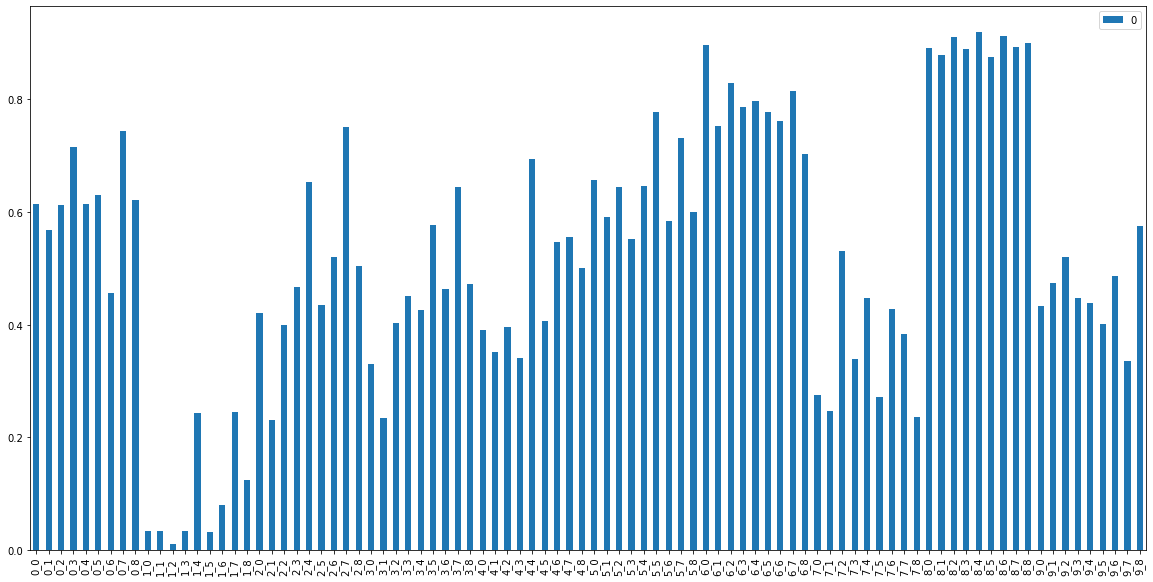

In [13]:
idd=80
devs[idd]
m = devs[idd].get_senders_perc_normal()
pd.DataFrame.from_dict(m, orient='index').plot.bar(figsize=(20,10))

In [14]:
out = ""
filegraph = dataset_name + '.ncol'
for m in devs:
    devs_federated = m.get_devs_federated(0.06)
    for i in devs_federated:
        if i != m:
            out = out + str(m)+'\t'+str(i)+"\n"
        elif len(devs_federated)==1:
            # come si mettono in ncol i vertici isolati? inconcludente, mettiano autoring per ora va bene
            out = out + str(m)+'\t'+str(i)+"\n"

with open(filegraph, 'w') as f:
    f.write(out)

8368

In [15]:
from igraph import *
toy_g = read(filegraph, format = "ncol", directed = True)
summary(toy_g, verbosity = 1, max_rows = 25, edge_list_format = "edgelist")
#assert toy_g.vcount() == 90

# come si mettono in ncol i vertici isolati? inconcludente
#toy_g.add_vertices(["80_10", "80_11"])
#write(toy_g, "./zfacebook.ncol", format = "ncol")

print(toy_g.vcount())

IGRAPH DN-- 90 1046 -- 
+ attr: name (v)
+ edges (vertex names):
         edge  
[0]    0_0->0_1
[1]    0_0->0_2
[2]    0_0->0_3
[3]    0_0->0_4
[4]    0_0->0_5
[5]    0_0->0_6
[6]    0_0->0_7
[7]    0_0->0_8
[8]    0_0->3_0
[9]    0_0->3_2
[10]   0_0->3_3
[11]   0_0->3_4
[12]   0_0->3_5
[13]   0_0->3_6
[14]   0_0->3_7
[15]   0_0->3_8
[16]   0_0->4_4
[17]   0_0->4_6
[18]   0_1->0_0
[19]   0_1->0_2
[20]   0_1->0_3
[21]   0_1->0_4
[22]   0_1->0_5
[23]   0_1->0_7
[24]   0_1->0_8
90


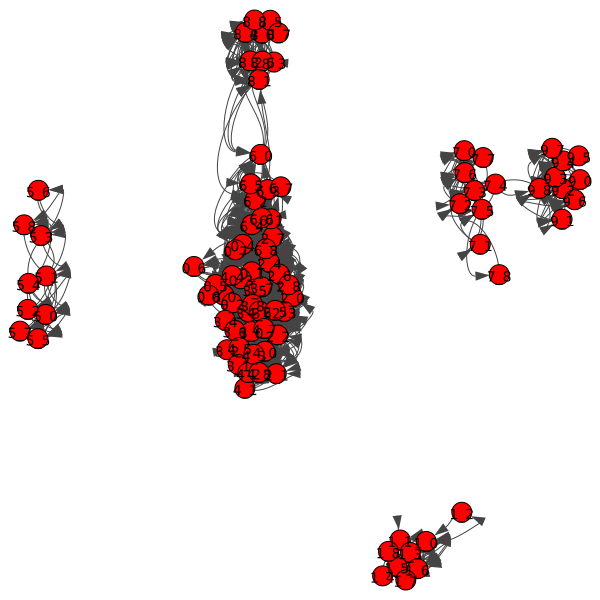

In [16]:
# Compute the layout, using one of the possible methods (Fructherman-Reingold)
toy_g.vs["label"] = toy_g.vs["name"]
layout = toy_g.layout_fruchterman_reingold()

# Plot the graph
plot(toy_g, layout = layout)

7

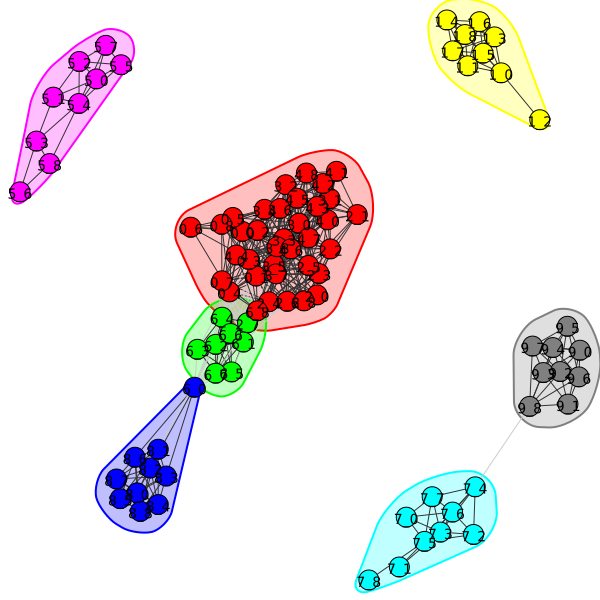

array([172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200,
       204, 205, 206, 207, 208, 209, 228, 229, 230, 231, 232, 266, 267,
       268, 269, 270, 271, 272, 278, 279, 280, 285, 286, 326, 397, 398,
       437, 461])

Clustering with 90 elements and 7 clusters
0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 3_0, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_6, 2_0, 2_3, 2_4, 2_5, 2_6, 6_8, 2_2, 4_5, 4_7, 2_8, 2_1, 3_1, 4_0, 4_1, 4_2, 4_3, 4_8
2_7, 6_1, 6_2, 6_4, 6_6, 6_3, 6_5, 6_7
6_0, 8_2, 8_3, 8_6, 8_1, 8_0, 8_4, 8_5, 8_7, 8_8
1_0, 1_1, 1_2, 1_3, 1_5, 1_6, 1_7, 1_8, 1_4
5_0, 5_1, 5_2, 5_4, 5_5, 5_7, 5_3, 5_6, 5_8
7_0, 7_3, 7_5, 7_6, 7_7, 7_1, 7_2, 7_4, 7_8
9_8, 9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7


In [17]:
toy_g_u = toy_g.as_undirected(combine_edges = "sum")
idx = np.argwhere(np.array(toy_g_u.degree())>0).flatten()
sub_g1 = toy_g_u.induced_subgraph(idx)

# Fastgreedy algorithm
vd = sub_g1.community_fastgreedy()



# The number of detected communities
vd.optimal_count

# convert to a cluster object to plot it nicely
vd_clust = vd.as_clustering()
plot(vd_clust, layout=sub_g1.layout_fruchterman_reingold(), mark_groups = True)

# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing())
np.argwhere(cros == True).flatten()
summary(vd_clust, verbosity = 1)
#summary(vd, verbosity = 1)

In [18]:
vd_clust.summary(verbosity=1)
with open('zz.txt', 'w') as f:
    f.write(vd_clust.summary(verbosity=1))

'Clustering with 90 elements and 7 clusters\n0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_8, 3_0, 3_2, 3_3, 3_4, 3_5, 3_6, 3_7, 3_8, 4_4, 4_6, 2_0, 2_3, 2_4, 2_5, 2_6, 6_8, 2_2, 4_5, 4_7, 2_8, 2_1, 3_1, 4_0, 4_1, 4_2, 4_3, 4_8\n2_7, 6_1, 6_2, 6_4, 6_6, 6_3, 6_5, 6_7\n6_0, 8_2, 8_3, 8_6, 8_1, 8_0, 8_4, 8_5, 8_7, 8_8\n1_0, 1_1, 1_2, 1_3, 1_5, 1_6, 1_7, 1_8, 1_4\n5_0, 5_1, 5_2, 5_4, 5_5, 5_7, 5_3, 5_6, 5_8\n7_0, 7_3, 7_5, 7_6, 7_7, 7_1, 7_2, 7_4, 7_8\n9_8, 9_0, 9_1, 9_2, 9_3, 9_4, 9_5, 9_6, 9_7'

485

In [39]:
with open('zz.txt') as file:
    lines = file.readlines()[1:]
    lines = [line.strip().split(',') for line in lines]

In [40]:
lines

[['0_0',
  ' 0_1',
  ' 0_2',
  ' 0_3',
  ' 0_4',
  ' 0_5',
  ' 0_6',
  ' 0_7',
  ' 0_8',
  ' 3_0',
  ' 3_2',
  ' 3_3',
  ' 3_4',
  ' 3_5',
  ' 3_6',
  ' 3_7',
  ' 3_8',
  ' 4_4',
  ' 4_6',
  ' 2_0',
  ' 2_3',
  ' 2_4',
  ' 2_5',
  ' 2_6',
  ' 6_8',
  ' 2_2',
  ' 4_5',
  ' 4_7',
  ' 2_8',
  ' 2_1',
  ' 3_1',
  ' 4_0',
  ' 4_1',
  ' 4_2',
  ' 4_3',
  ' 4_8'],
 ['2_7', ' 6_1', ' 6_2', ' 6_4', ' 6_6', ' 6_3', ' 6_5', ' 6_7'],
 ['6_0',
  ' 8_2',
  ' 8_3',
  ' 8_6',
  ' 8_1',
  ' 8_0',
  ' 8_4',
  ' 8_5',
  ' 8_7',
  ' 8_8'],
 ['1_0', ' 1_1', ' 1_2', ' 1_3', ' 1_5', ' 1_6', ' 1_7', ' 1_8', ' 1_4'],
 ['5_0', ' 5_1', ' 5_2', ' 5_4', ' 5_5', ' 5_7', ' 5_3', ' 5_6', ' 5_8'],
 ['7_0', ' 7_3', ' 7_5', ' 7_6', ' 7_7', ' 7_1', ' 7_2', ' 7_4', ' 7_8'],
 ['9_8', ' 9_0', ' 9_1', ' 9_2', ' 9_3', ' 9_4', ' 9_5', ' 9_6', ' 9_7']]

In [41]:
filename = 'clust_'+dataset_name+str(num_nodes_per_class)+'.txt'
#vd_clust.summary(verbosity=1)
#with open(filename, 'w') as f:
    #f.write(vd_clust.summary(verbosity=1))

lll = [sorted(i.strip().replace(' ', '').split(',')) for i in vd_clust.summary(verbosity=1).split("\n")]
with open(filename, 'w') as f:
    for line in lll:
        f.write(', '.join(line)+'\n')

37

179

39

49

44

44

44

44

: 